In [15]:
!pip install imbalanced-learn xgboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE



In [19]:
from google.colab import files
uploaded = files.upload()

Saving creditcard.csv to creditcard (1).csv


In [20]:
# Load your dataset
df = pd.read_csv("creditcard.csv")

In [23]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [24]:
# Features and target
X = df.drop(['Class'], axis=1)
y = df['Class']


<ipython-input-54-9b611e73f5a4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='Set2')


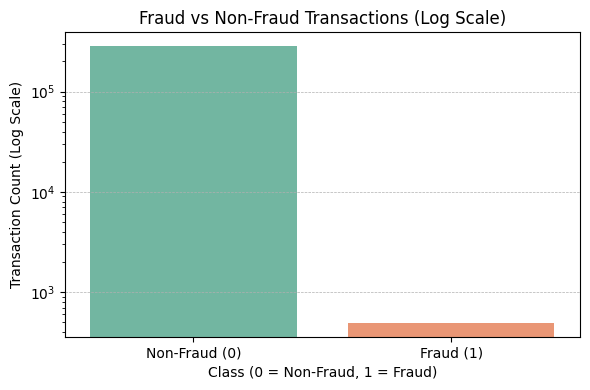

In [54]:
# Plot with log scale
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df, palette='Set2')
plt.yscale('log')  # Set y-axis to log scale
plt.title('Fraud vs Non-Fraud Transactions (Log Scale)')
plt.xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Transaction Count (Log Scale)')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

<ipython-input-52-e5dd609bb453>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_df['Hour_Bucket'] = pd.cut(fraud_df['Hour'], bins=bins, labels=labels, right=False)
<ipython-input-52-e5dd609bb453>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bucket_counts.index, y=bucket_counts.values, palette="rocket")


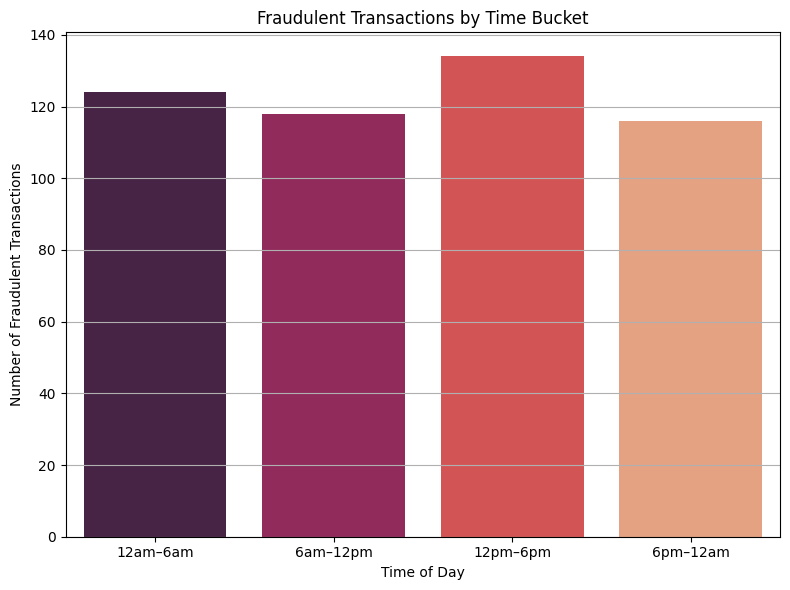

In [52]:
# Convert Time to hour of the day (0–23)
df['Hour'] = (df['Time'] / 3600).astype(int) % 24

# Filter only fraudulent transactions
fraud_df = df[df['Class'] == 1]

# Define hour buckets
bins = [0, 6, 12, 18, 24]
labels = ['12am–6am', '6am–12pm', '12pm–6pm', '6pm–12am']
fraud_df['Hour_Bucket'] = pd.cut(fraud_df['Hour'], bins=bins, labels=labels, right=False)

# Count frauds by bucket
bucket_counts = fraud_df['Hour_Bucket'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x=bucket_counts.index, y=bucket_counts.values, palette="rocket")
plt.title("Fraudulent Transactions by Time Bucket")
plt.xlabel("Time of Day")
plt.ylabel("Number of Fraudulent Transactions")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


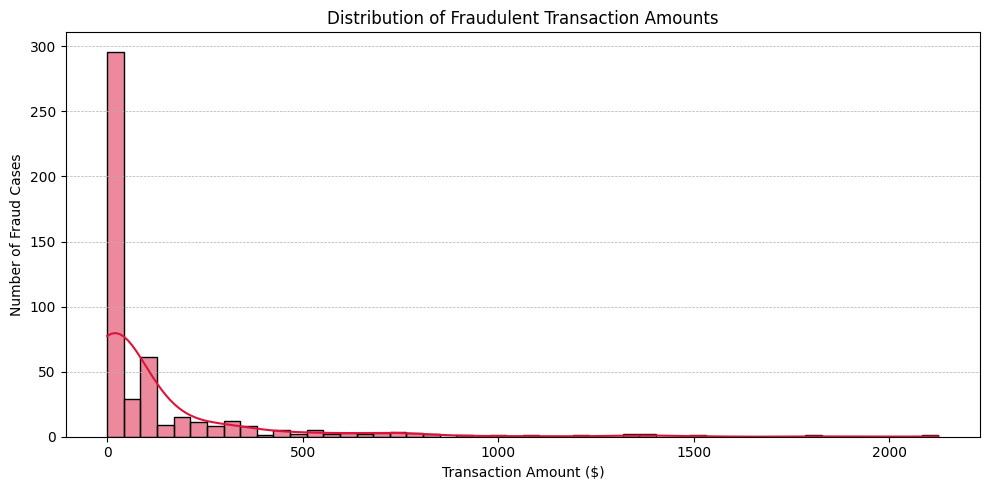

In [55]:
fraud_df = df[df['Class'] == 1]

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(fraud_df['Amount'], bins=50, color='crimson', kde=True)
plt.title("Distribution of Fraudulent Transaction Amounts")
plt.xlabel("Transaction Amount ($)")
plt.ylabel("Number of Fraud Cases")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


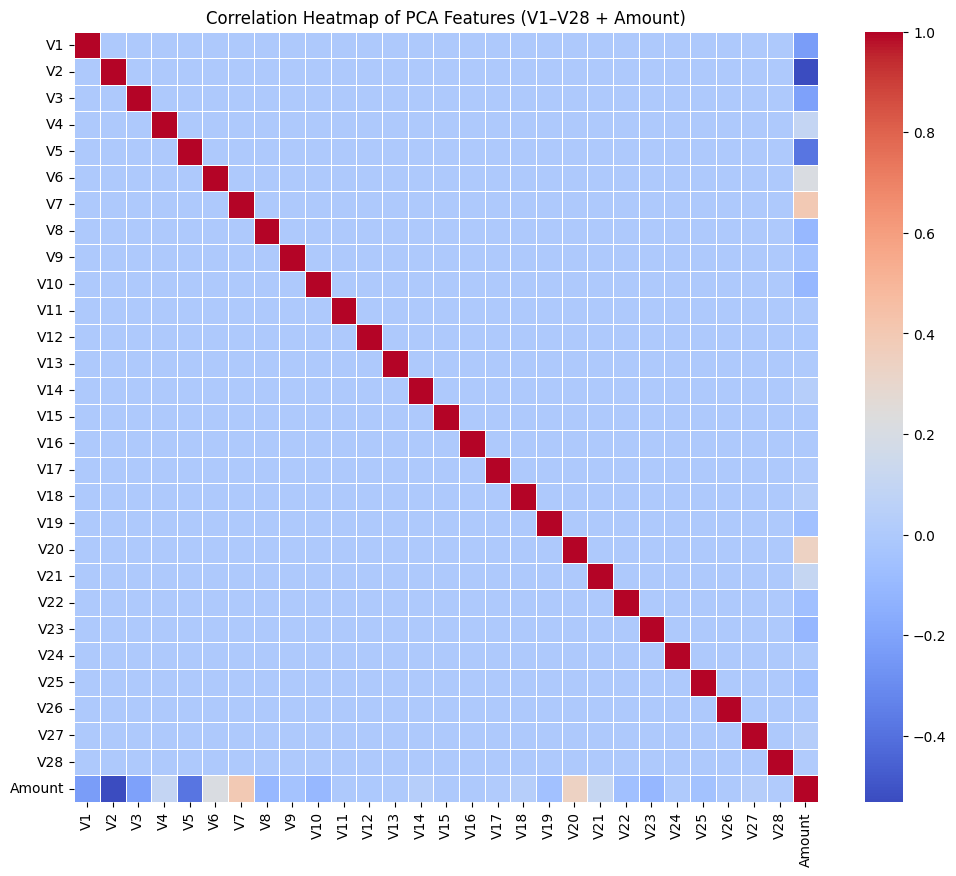

In [41]:
plt.figure(figsize=(12,10))
corr = df.drop(['Time', 'Class'], axis=1).corr()
sns.heatmap(corr, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of PCA Features (V1–V28 + Amount)')
plt.show()


In [26]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [27]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

In [28]:
# SMOTE to balance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [29]:
# Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}


In [30]:
# Train, test, and store F1 scores
f1_scores = {}
for name, model in models.items():
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores[name] = f1
    print(f"\n{name}:\n{classification_report(y_test, y_pred)}")


Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.98      0.99     85443


Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.90      0.78      0.83       148

    accuracy                           1.00     85443
   macro avg       0.95      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:14:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.74      0.80      0.77       148

    accuracy                           1.00     85443
   macro avg       0.87      0.90      0.89     85443
weighted avg       1.00      1.00      1.00     85443



In [32]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix

# Refit the XGBoost model using SMOTE-balanced data
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_res, y_res)

# Predict probabilities instead of classes
y_proba = xgb.predict_proba(X_test)[:, 1]

# Use precision-recall curve to get the best threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Best threshold based on F1 score: {best_threshold:.3f}")

# Use the best threshold to make final predictions
y_pred_thresh = (y_proba >= best_threshold).astype(int)

# Print classification report and confusion matrix
print("\nClassification Report (after threshold tuning):")
print(classification_report(y_test, y_pred_thresh))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_thresh))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:23:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best threshold based on F1 score: 0.886

Classification Report (after threshold tuning):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.93      0.77      0.84       148

    accuracy                           1.00     85443
   macro avg       0.96      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Confusion Matrix:
[[85286     9]
 [   34   114]]


Logistic Regression - Best Threshold: 1.00 | F1 Score: 0.8100
Random Forest - Best Threshold: 0.75 | F1 Score: 0.8340


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:51:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Best Threshold: 0.89 | F1 Score: 0.8413


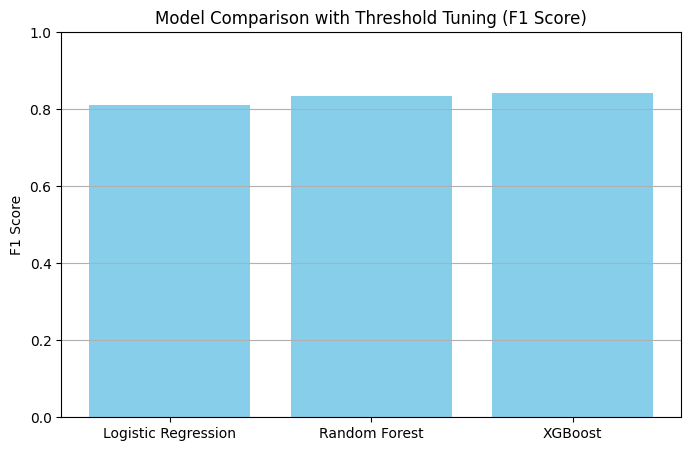

In [34]:


# Threshold tuning and F1 score collection
f1_scores = {}

for name, model in models.items():
    model.fit(X_res, y_res)
    y_probs = model.predict_proba(X_test)[:, 1]  # predicted probabilities for class 1
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    f1s = 2 * (precision * recall) / (precision + recall + 1e-6)
    best_thresh = thresholds[np.argmax(f1s)]
    best_f1 = max(f1s)
    f1_scores[name] = best_f1
    print(f"{name} - Best Threshold: {best_thresh:.2f} | F1 Score: {best_f1:.4f}")

# Plot the results
plt.figure(figsize=(8, 5))
plt.bar(f1_scores.keys(), f1_scores.values(), color='skyblue')
plt.title("Model Comparison with Threshold Tuning (F1 Score)")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()
